# **Import Necessary Libraries**

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# **Load the Dataset**

In [35]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# **Understand And Organize the Datase**

In [36]:
# Check data types
print(f"x_train data type: {type(x_train)}")
print(f"y_train data type: {type(y_train)}")
print(f"x_test data type: {type(x_test)}")
print(f"y_test data type: {type(y_test)}\n")

# Check shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

# Check unique values in target variables
print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Unique values in y_test: {np.unique(y_test)}\n")

# Check if there is any missing data
print(f"Any missing values in x_train: {np.any(np.isnan(x_train))}")
print(f"Any missing values in y_train: {np.any(np.isnan(y_train))}")
print(f"Any missing values in x_test: {np.any(np.isnan(x_test))}")
print(f"Any missing values in y_test: {np.any(np.isnan(y_test))}")

x_train data type: <class 'numpy.ndarray'>
y_train data type: <class 'numpy.ndarray'>
x_test data type: <class 'numpy.ndarray'>
y_test data type: <class 'numpy.ndarray'>

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)

Unique values in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique values in y_test: [0 1 2 3 4 5 6 7 8 9]

Any missing values in x_train: False
Any missing values in y_train: False
Any missing values in x_test: False
Any missing values in y_test: False


***How many different label values do we have?***

In [37]:
num_labels = len(np.unique(y_train))
num_labels

10

## **Frequency Distribution of Target Labels y_train and y_test**

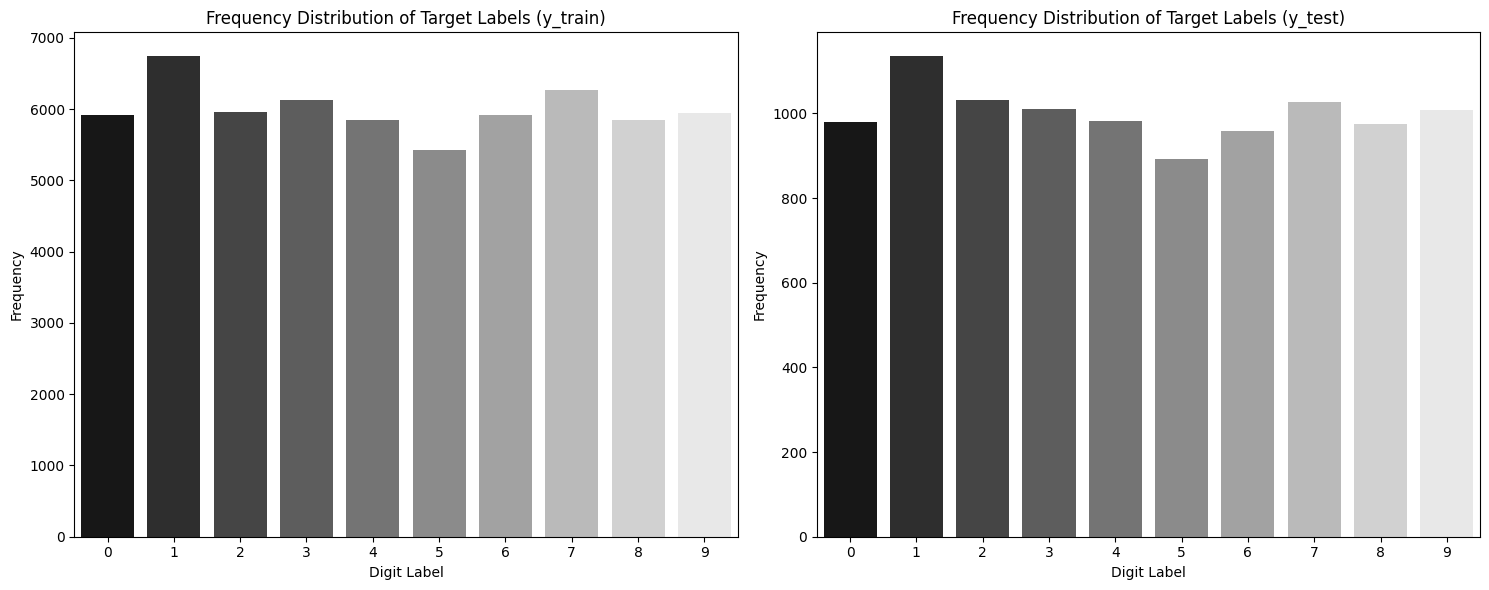

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x=y_train, palette='gray', ax=axes[0])
axes[0].set_title('Frequency Distribution of Target Labels (y_train)')
axes[0].set_xlabel('Digit Label')
axes[0].set_ylabel('Frequency')

sns.countplot(x=y_test, palette='gray', ax=axes[1])
axes[1].set_title('Frequency Distribution of Target Labels (y_test)')
axes[1].set_xlabel('Digit Label')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## **Visualization of Some Digits and Their Labels**

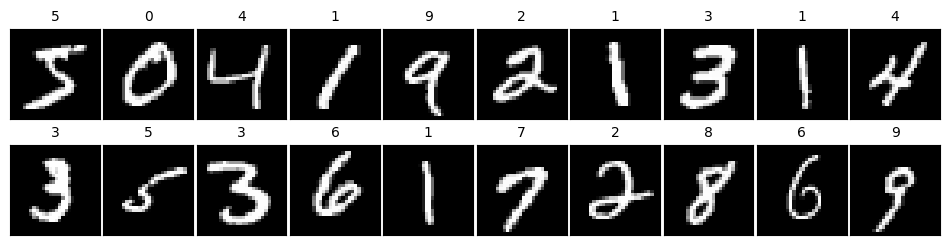

In [39]:
def visualize_images(data):
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(12,3),
                             gridspec_kw={'wspace':0.04, 'hspace':0.01}, 
                             squeeze=True)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_train[i], cmap='gray')
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_title(str(y_train[i]), fontsize=10)
        
    plt.tight_layout()
    plt.show()

visualize_images(x_train)

## **Visualizing an Image with Pixel Values**

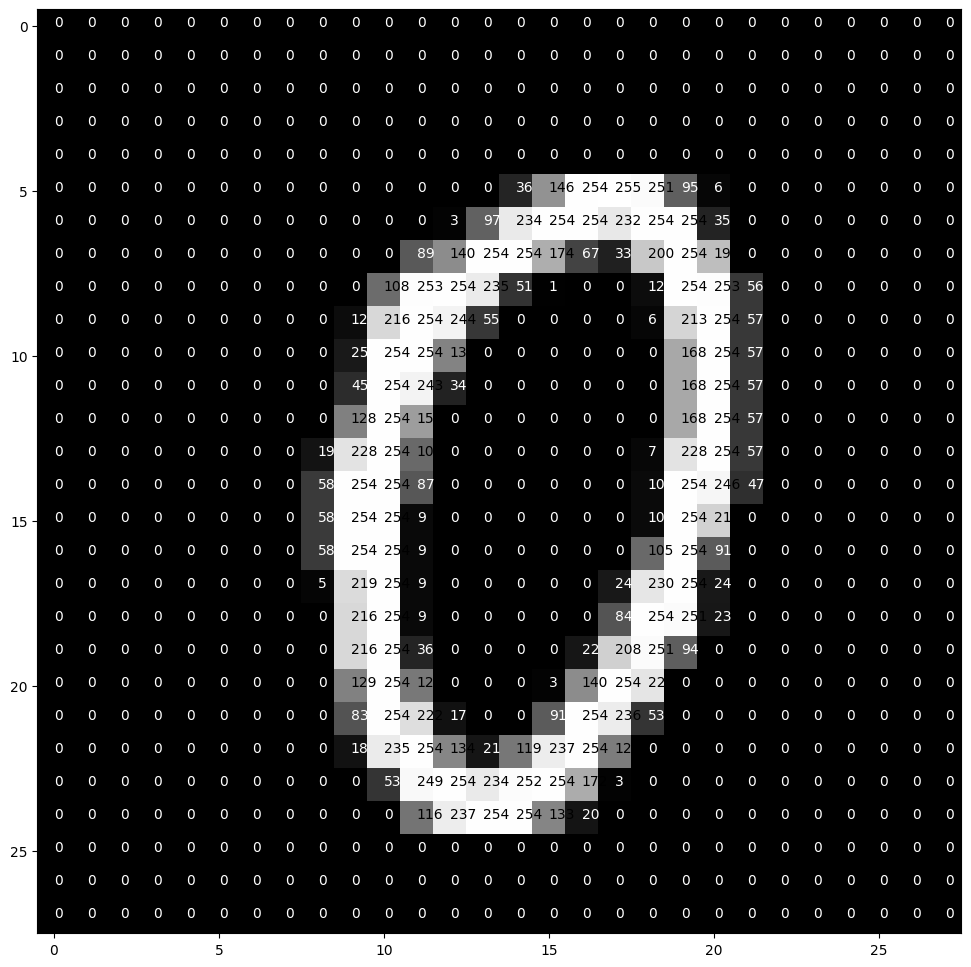

In [40]:
def pixel_visualize(img):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")
    width, height = img.shape
    threshold = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy=(y,x), 
                       color='white' if img [x][y]<threshold else 'black')

pixel_visualize(x_train[1000])

##  **Preprocessing**

In [41]:
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [42]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [43]:
y_train[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [44]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [45]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# **Model Building**

In [46]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"])

In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 892,266 (3.40 MB)

 Trainable params: 891,050 (3.40 MB)

 Non-trainable params: 1,216 (4.75 KB)

## **Using ImageDataGenerator**

In [48]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(x_train)

## **EarlyStopping**

In [50]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(x_train, y_train, batch_size=512), epochs=50, 
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9825 - loss: 0.0541 - precision_1: 0.9846 - recall_1: 0.9813 - val_accuracy: 0.9946 - val_loss: 0.0176 - val_precision_1: 0.9951 - val_recall_1: 0.9942
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9823 - loss: 0.0568 - precision_1: 0.9846 - recall_1: 0.9807 - val_accuracy: 0.9944 - val_loss: 0.0155 - val_precision_1: 0.9948 - val_recall_1: 0.9944
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9832 - loss: 0.0530 - precision_1: 0.9857 - recall_1: 0.9816 - val_accuracy: 0.9921 - val_loss: 0.0238 - val_precision_1: 0.9931 - val_recall_1: 0.9914
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.9832 - loss: 0.0548 - precision_1: 0.9851 - recall_1: 0.9818 - val_accuracy: 0.9926 - val_loss: 0.0227 - val_precision_1: 0.9932 - val_recall_1: 0.9917
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9844 - loss: 0.0529 - precision_1: 0.9862 - rec

# **Results and Visualization of the Model**

In [51]:
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## **Classification Report**

In [52]:
class_labels = ['0','1','2','3','4','5','6','7','8','9']
report = classification_report(y_true, y_pred_class, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## **Train & Test Accuracy and Loss** 

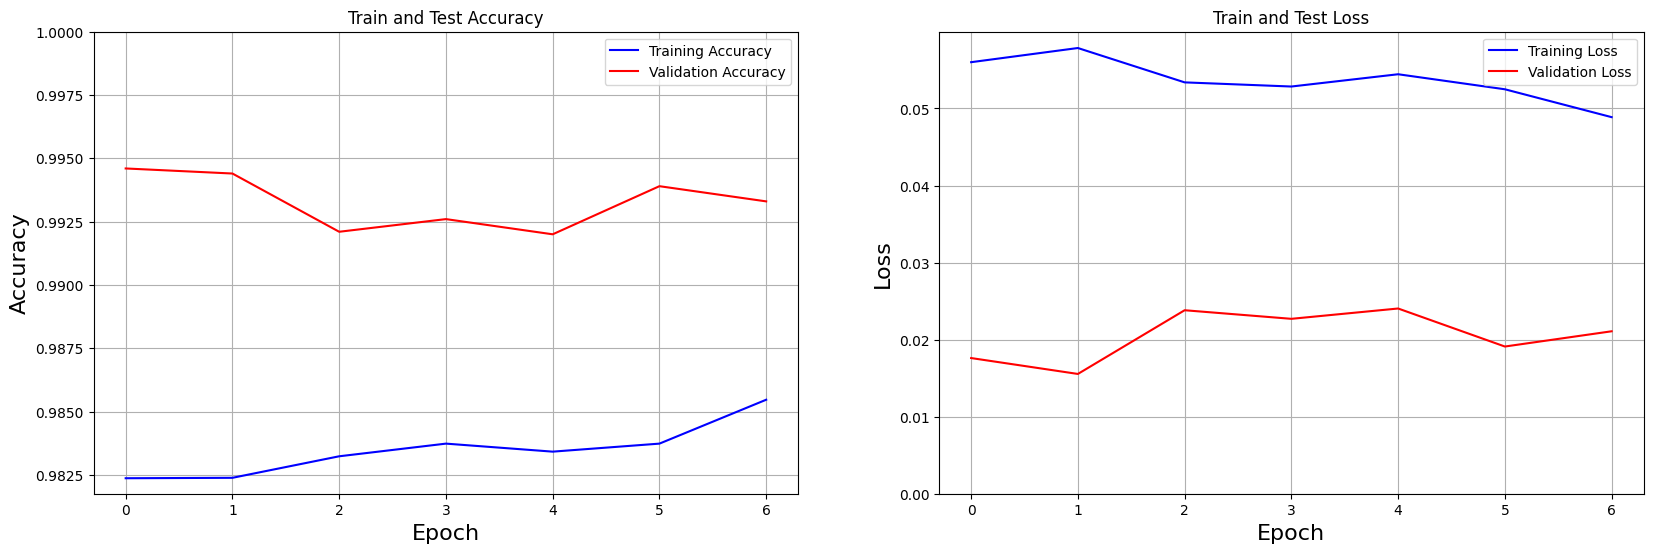

In [53]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Train and Test Accuracy')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Train and Test Loss')
plt.grid(True)
plt.show()

In [54]:
loss, precision, recall, acc=model.evaluate(x_test, y_test, verbose=False)
print('Test Accuracy: ', acc)
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)

Test Accuracy:  0.9944000244140625
Test Loss:  0.015544398687779903
Test Precision:  0.994797945022583
Test Recall:  0.9944000244140625


# **Model Saving**

In [55]:
model.save('mnist_model.h5')

# **Testing Results**

In [56]:
import random
random = random.randint(0, x_test.shape[0])
random

6049

In [57]:
test_image = x_test[random]
y_test[random]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

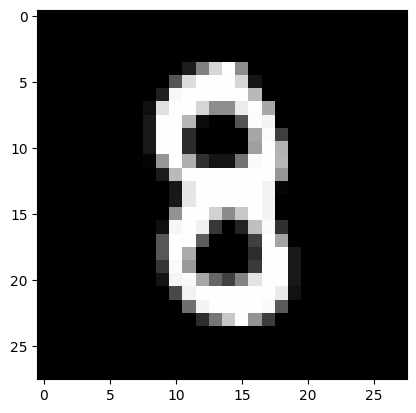

In [58]:
plt.imshow(test_image.reshape(28,28), cmap='gray');

In [59]:
test_data = x_test[random].reshape(1,28,28,1)
probability = model.predict(test_data)
probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


array([[9.3356469e-08, 2.7499517e-10, 2.0303121e-07, 5.2199905e-08,
        5.3794430e-10, 8.9943164e-09, 8.0770178e-08, 4.6258322e-10,
        9.9999940e-01, 7.1308939e-08]], dtype=float32)

In [60]:
predicted_classes = np.argmax(probability)
predicted_classes

8

In [61]:
print(f'Predicted class: {predicted_classes}')
print(f'Predicted class probability value: {(np.argmax(probability, axis=-1))[0]}')
print(f'Probability values of other classes: \n{probability}')

Predicted class: 8
Predicted class probability value: 8
Probability values of other classes: 
[[9.3356469e-08 2.7499517e-10 2.0303121e-07 5.2199905e-08 5.3794430e-10
  8.9943164e-09 8.0770178e-08 4.6258322e-10 9.9999940e-01 7.1308939e-08]]


# **Misclassified Samples**

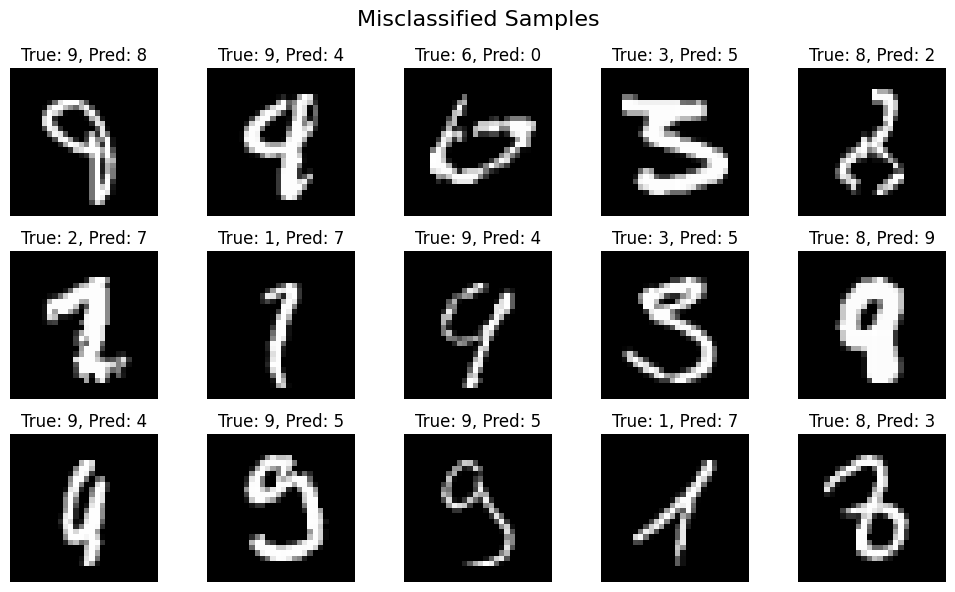

In [62]:
y_test_labels = np.argmax(y_test, axis=1)

misclassified_idx = np.where(y_pred_class != y_test_labels)[0]

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle("Misclassified Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = misclassified_idx[i]
    ax.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test_labels[idx]}, Pred: {y_pred_class[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# **Classification Accuracy Per Digit**

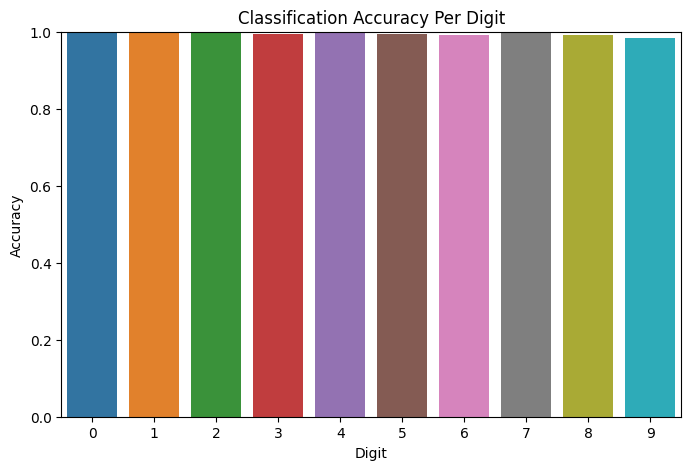

In [63]:
num_classes = 10
class_accuracies = []

for i in range(num_classes):
    correct = np.sum((y_test_labels == i) & (y_pred_class == i))
    total = np.sum(y_test_labels == i)
    accuracy = correct / total if total > 0 else 0
    class_accuracies.append(accuracy)

df = pd.DataFrame({"Digit": range(10), "Accuracy": class_accuracies})

plt.figure(figsize=(8, 5))
sns.barplot(x="Digit", y="Accuracy", data=df)
plt.ylim(0, 1)
plt.xlabel("Digit")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy Per Digit")
plt.show()

# **Confusion Matrix** 

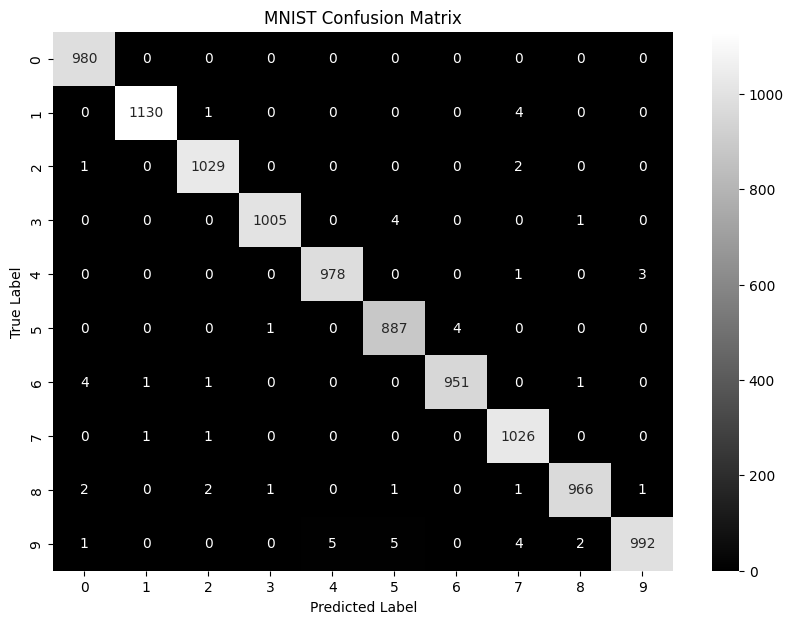

In [64]:
y_pred_labels = y_pred_class
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="gray", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MNIST Confusion Matrix")
plt.show()